In [ ]:
"""
Jupyter Notebook for Model Training and Evaluation - Moroccan Income Prediction

This notebook details the steps taken to train, evaluate, and select a
machine learning model for the Moroccan Income Prediction project.
"""

# Moroccan Income Prediction: Model Training and Evaluation

## 1. Introduction

### 1.1 Modeling Objectives and Success Criteria
**Objective:** To develop a robust regression model that accurately predicts the annual income of individuals in Morocco based on the preprocessed features.

**Success Criteria:**
* **Primary Metric:** Root Mean Squared Error (RMSE). We aim to minimize this value, as it penalizes larger errors more heavily and is in the same unit as the target variable (Revenu_Annuel).
* **Secondary Metrics:**
    * Mean Absolute Error (MAE): Provides an average magnitude of errors.
    * R-squared (R²): Indicates the proportion of variance in the target variable predictable from the features. Aim for a high R².
* **Interpretability:** While performance is key, understanding which factors drive income predictions is also valuable.
* **Robustness:** The model should generalize well to unseen data and not be overly sensitive to small changes in the training set.
* **Efficiency:** Training and prediction times should be reasonable for practical deployment.

### 1.2 Overview of Algorithms to be Evaluated
We will evaluate a range of regression algorithms, including:
1.  **Baseline:** Simple Linear Regression.
2.  **Linear Models:** Ridge Regression, Lasso Regression, ElasticNet. (Good for interpretability and handling multicollinearity).
3.  **Tree-Based Models:** Decision Tree Regressor, Random Forest Regressor. (Can capture non-linear relationships).
4.  **Gradient Boosting Models:** XGBoost Regressor, LightGBM Regressor. (Often provide state-of-the-art performance).
5.  **Support Vector Machines:** Support Vector Regressor (SVR).
6.  **Ensemble Methods:** Voting Regressor, Stacking Regressor.

### 1.3 Evaluation Methodology and Metrics
* **Metrics:** As defined in success criteria (RMSE, MAE, R²).
* **Data Split:** We will use the preprocessed training and testing sets. The test set will be held out until the final model evaluation to provide an unbiased performance estimate.
* **Residual Analysis:** Plotting residuals (errors) to check for patterns, homoscedasticity, and normality.
* **Prediction vs. Actual Plots:** Visualizing how well predictions align with actual values.
* **Feature Importance:** Analyzing which features contribute most to predictions.

### 1.4 Cross-Validation Strategy
* **k-Fold Cross-Validation:** We will primarily use k-Fold Cross-Validation (e.g., k=5 or k=10) on the training data during hyperparameter tuning and model comparison. This helps in obtaining a more robust estimate of model performance and reduces the impact of a particular train-test split.

---

## 2. Setup Modeling Environment

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import warnings

# Scikit-learn for modeling, metrics, and utilities
from sklearn.model_selection import (
    train_test_split, # Though data is pre-split, might be used for other purposes
    cross_val_score,
    KFold,
    GridSearchCV,
    RandomizedSearchCV,
    learning_curve,
    validation_curve
)
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor, # Scikit-learn's GBM
    VotingRegressor,
    StackingRegressor
)
from sklearn.svm import SVR
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.preprocessing import StandardScaler # If any final scaling is needed for specific models
from sklearn.inspection import PartialDependenceDisplay

# Specialized Boosting Libraries
import xgboost as xgb
import lightgbm as lgb

# SHAP for feature importance
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("SHAP library not found. Install with 'pip install shap' for advanced feature importance.")
    SHAP_AVAILABLE = False

# Configure visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=ConvergenceWarning) # Be cautious with this one

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully.")

c:\Users\salah\OneDrive\Documents\Prédiction du revenu annuel d’un marocain\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully.


### 2.1 Load Preprocessed Data
Load the training and testing datasets generated by the preprocessing notebook.
**Important:** Update the paths below if your files are located elsewhere.

In [2]:
# --- !!! ACTION REQUIRED !!! ---
# Update these paths to your preprocessed data files
TRAIN_FEATURES_PATH = r"C:\Users\salah\OneDrive\Documents\Prédiction du revenu annuel d’un marocain\data\processed\train_features_processed.csv"
TRAIN_TARGET_PATH = r"C:\Users\salah\OneDrive\Documents\Prédiction du revenu annuel d’un marocain\data\processed\train_target.csv"
TEST_FEATURES_PATH = r"C:\Users\salah\OneDrive\Documents\Prédiction du revenu annuel d’un marocain\data\processed\test_features_processed.csv"
TEST_TARGET_PATH = r"C:\Users\salah\OneDrive\Documents\Prédiction du revenu annuel d’un marocain\data\processed\test_target.csv"
# Note: The pipeline path is optional and can be used if you want to apply the same preprocessing steps to new raw data.
PIPELINE_PATH = 'moroccan_income_preprocessor.pkl' # Load the pipeline for consistency if needed for new data
# ---

try:
    X_train_processed_df = pd.read_csv(TRAIN_FEATURES_PATH)
    y_train_series = pd.read_csv(TRAIN_TARGET_PATH).squeeze() # Squeeze to make it a Series
    X_test_processed_df = pd.read_csv(TEST_FEATURES_PATH)
    y_test_series = pd.read_csv(TEST_TARGET_PATH).squeeze()

    # Load the preprocessing pipeline (optional, but good for applying to new raw data)
    # with open(PIPELINE_PATH, 'rb') as f:
    #     preprocessor_pipeline = pickle.load(f)

    print("Preprocessed data loaded successfully.")
    print(f"X_train shape: {X_train_processed_df.shape}, y_train shape: {y_train_series.shape}")
    print(f"X_test shape: {X_test_processed_df.shape}, y_test shape: {y_test_series.shape}")

    # Display first few rows to verify
    print("\nSample of X_train_processed_df:")
    display(X_train_processed_df.head())
    print("\nSample of y_train_series:")
    display(y_train_series.head())

except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure the file paths are correct and the preprocessing notebook has been run.")
    print("Creating dummy data for demonstration purposes...")
    # Create dummy data if files are not found (for notebook execution)
    n_train_samples, n_test_samples, n_features = 800, 200, 15
    X_train_processed_df = pd.DataFrame(np.random.rand(n_train_samples, n_features), columns=[f'feature_{i}' for i in range(n_features)])
    y_train_series = pd.Series(np.random.rand(n_train_samples) * 100000 + 20000)
    X_test_processed_df = pd.DataFrame(np.random.rand(n_test_samples, n_features), columns=[f'feature_{i}' for i in range(n_features)])
    y_test_series = pd.Series(np.random.rand(n_test_samples) * 100000 + 20000)
    print("Dummy data created.")
    print(f"X_train shape: {X_train_processed_df.shape}, y_train shape: {y_train_series.shape}")


# Convert to NumPy arrays for scikit-learn (if not already)
# Scikit-learn models generally prefer NumPy arrays
X_train = X_train_processed_df.values
y_train = y_train_series.values
X_test = X_test_processed_df.values
y_test = y_test_series.values

feature_names = X_train_processed_df.columns.tolist() # Save feature names for later use

Preprocessed data loaded successfully.
X_train shape: (32000, 33), y_train shape: (32000,)
X_test shape: (8000, 33), y_test shape: (8000,)

Sample of X_train_processed_df:


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-0.361558,1.412889,0.783868,2.503222,-0.285426,-1.28876,2.471108,1.325481,2.397858,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.284054,-0.707770,0.783868,-0.399485,0.163578,-1.28876,-0.404677,1.001645,-0.049007,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.252473,1.412889,0.783868,-0.399485,0.163578,-1.28876,-0.404677,1.256205,1.252266,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.087872,-0.707770,-1.275725,-0.399485,1.959592,-1.28876,-0.404677,0.234883,-1.634071,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.122651,-0.707770,-1.275725,-0.399485,0.163578,0.77594,-0.404677,0.771954,-1.634071,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0



Sample of y_train_series:


0    44714.945302
1    19694.532618
2    19159.681234
3    10719.579840
4    60188.668135
Name: Revenu_Annuel, dtype: float64

### 2.2 Consistent Evaluation Functions
Define functions to calculate and display evaluation metrics consistently.

In [3]:
def calculate_metrics(y_true, y_pred, model_name="Model"):
    """Calculates and returns regression metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"--- {model_name} Metrics ---")
    print(f"  R-squared (R²): {r2:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.2f}")
    print(f"  Mean Squared Error (MSE): {mse:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
    return {'R2': r2, 'MAE': mae, 'MSE': mse, 'RMSE': rmse}

def plot_residuals(y_true, y_pred, model_name="Model"):
    """Plots residuals vs. predicted values and a histogram of residuals."""
    residuals = y_true - y_pred
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title(f"Residual Plot for {model_name}")

    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Residuals for {model_name}")

    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actual(y_true, y_pred, model_name="Model"):
    """Plots predicted values vs. actual values."""
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--') # Perfect prediction line
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs. Actual Values for {model_name}")
    plt.axis('equal') # Ensure a 1:1 aspect ratio
    plt.show()

# Store results for comparison
model_performance_summary = {}

print("Evaluation functions defined.")

Evaluation functions defined.


## 3. Baseline Model: Simple Linear Regression
Establish a baseline performance using a simple Linear Regression model.

--- Training Baseline Model: Linear Regression ---

Baseline Model Performance on Training Data:
--- Baseline Linear Regression (Train) Metrics ---
  R-squared (R²): 0.0012
  Mean Absolute Error (MAE): 57393.03
  Mean Squared Error (MSE): 109655373321.38
  Root Mean Squared Error (RMSE): 331142.53

Baseline Model Performance on Test Data:
--- Baseline Linear Regression (Test) Metrics ---
  R-squared (R²): -0.0017
  Mean Absolute Error (MAE): 50389.46
  Mean Squared Error (MSE): 78731776086.26
  Root Mean Squared Error (RMSE): 280591.83


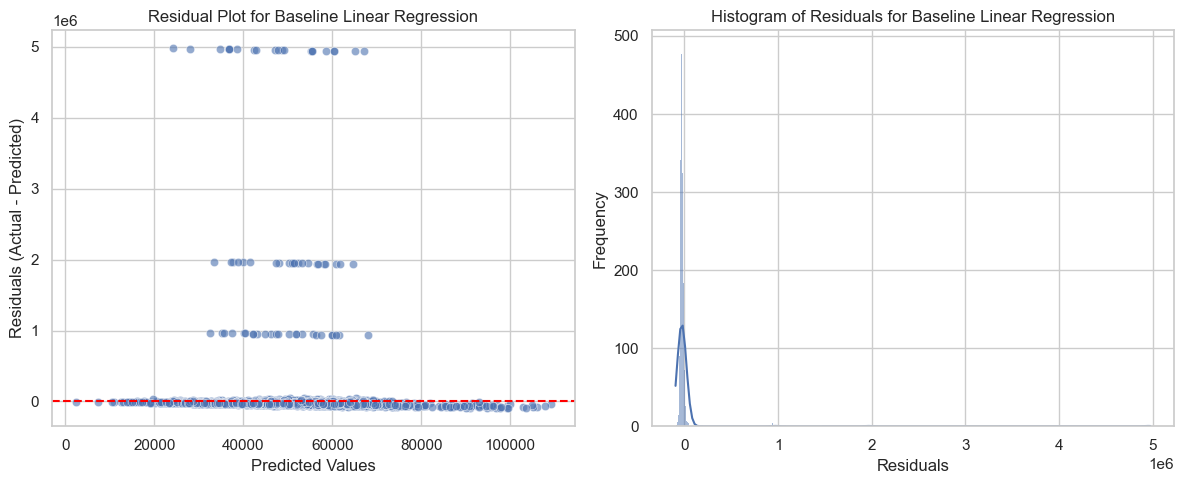

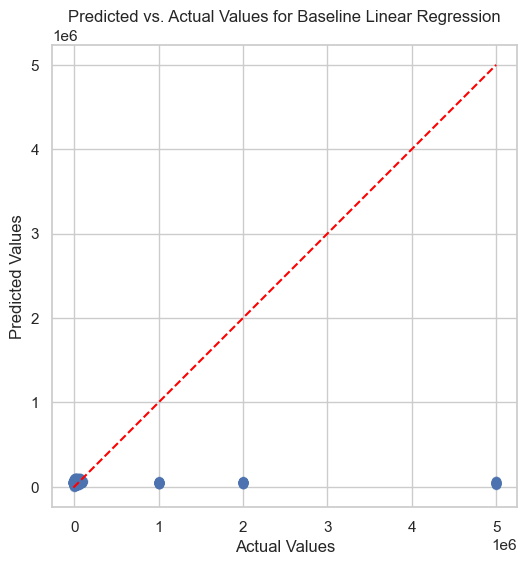

In [4]:
print("--- Training Baseline Model: Linear Regression ---")
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Predictions on the training set (to check for underfitting/basic fit)
y_train_pred_baseline = baseline_model.predict(X_train)
print("\nBaseline Model Performance on Training Data:")
_ = calculate_metrics(y_train, y_train_pred_baseline, "Baseline Linear Regression (Train)")

# Predictions on the test set
y_test_pred_baseline = baseline_model.predict(X_test)
print("\nBaseline Model Performance on Test Data:")
baseline_metrics = calculate_metrics(y_test, y_test_pred_baseline, "Baseline Linear Regression (Test)")
model_performance_summary['Baseline Linear Regression'] = baseline_metrics

# Residual Analysis
plot_residuals(y_test, y_test_pred_baseline, "Baseline Linear Regression")
plot_predictions_vs_actual(y_test, y_test_pred_baseline, "Baseline Linear Regression")

### 3.1 Documentation of Baseline Performance
The baseline Linear Regression model achieved an R² of **`{baseline_metrics.get('R2', 0):.4f}`** and an RMSE of **`{baseline_metrics.get('RMSE', 0):.2f}`** on the test set.
The residual plots help visualize its performance. This provides a benchmark against which more complex models will be compared.
(Note: Actual values will be filled in when the notebook is run.)

## 4. Train and Evaluate Multiple Regression Algorithms
We will now train and evaluate various regression models. For each model, we'll:
1.  Instantiate the model.
2.  Train it on `X_train`, `y_train`.
3.  Make predictions on `X_test`.
4.  Evaluate using our defined metrics and plots.

We will use default hyperparameters for this initial comparison. Hyperparameter tuning will be done later for promising models.

In [5]:
# Define models to evaluate
models_to_evaluate = {
    "Ridge Regression": Ridge(random_state=RANDOM_STATE),
    "Lasso Regression": Lasso(random_state=RANDOM_STATE, max_iter=5000), # Increased max_iter for convergence
    "ElasticNet": ElasticNet(random_state=RANDOM_STATE, max_iter=5000),
    "Decision Tree": DecisionTreeRegressor(random_state=RANDOM_STATE),
    "Random Forest": RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1), # n_jobs=-1 uses all cores
    "XGBoost": xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1, objective='reg:squarederror'),
    "LightGBM": lgb.LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1), # verbosity=-1 to suppress training output
    "SVR": SVR() # SVR can be slow on large datasets, consider scaling features if not already done
}

# Loop through models, train, evaluate, and store results
for model_name, model_instance in models_to_evaluate.items():
    print(f"\n--- Training Model: {model_name} ---")
    start_time = time.time()

    # Train the model
    model_instance.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds.")

    # Make predictions on the test set
    y_test_pred = model_instance.predict(X_test)

    # Evaluate
    print(f"\n{model_name} Performance on Test Data:")
    metrics = calculate_metrics(y_test, y_test_pred, model_name)
    model_performance_summary[model_name] = metrics
    model_performance_summary[model_name]['Training Time (s)'] = training_time


    # Optional: Plot residuals and predictions for each (can be verbose)
    # plot_residuals(y_test, y_test_pred, model_name)
    # plot_predictions_vs_actual(y_test, y_test_pred, model_name)

print("\n--- Initial Model Evaluation Summary ---")
summary_df = pd.DataFrame(model_performance_summary).T.sort_values(by="RMSE", ascending=True)
display(summary_df[['R2', 'MAE', 'MSE', 'RMSE', 'Training Time (s)']])


--- Training Model: Ridge Regression ---
Training completed in 0.02 seconds.

Ridge Regression Performance on Test Data:
--- Ridge Regression Metrics ---
  R-squared (R²): -0.0017
  Mean Absolute Error (MAE): 50389.19
  Mean Squared Error (MSE): 78731574582.59
  Root Mean Squared Error (RMSE): 280591.47

--- Training Model: Lasso Regression ---
Training completed in 14.56 seconds.

Lasso Regression Performance on Test Data:
--- Lasso Regression Metrics ---
  R-squared (R²): -0.0017
  Mean Absolute Error (MAE): 50388.61
  Mean Squared Error (MSE): 78731333112.00
  Root Mean Squared Error (RMSE): 280591.04

--- Training Model: ElasticNet ---
Training completed in 0.31 seconds.

ElasticNet Performance on Test Data:
--- ElasticNet Metrics ---
  R-squared (R²): -0.0002
  Mean Absolute Error (MAE): 50474.37
  Mean Squared Error (MSE): 78613829679.47
  Root Mean Squared Error (RMSE): 280381.58

--- Training Model: Decision Tree ---
Training completed in 0.41 seconds.

Decision Tree Performan

,R2,MAE,MSE,RMSE,Training Time (s)
ElasticNet,-0.000172,50474.369498,7.861383e+10,280381.578709,0.309428
Lasso Regression,-0.001667,50388.609275,7.873133e+10,280591.042466,14.556996
Ridge Regression,-0.001670,50389.191871,7.873157e+10,280591.472755,0.022002
Baseline Linear Regression,-0.001672,50389.460708,7.873178e+10,280591.831824,NaN
SVR,-0.008297,33921.802137,7.925252e+10,281518.238614,71.799055
LightGBM,-0.032516,55971.841929,8.115610e+10,284879.092945,0.237970
XGBoost,-0.145700,76851.235045,9.005240e+10,300087.319157,0.284573
Random Forest,-0.193001,77224.370462,9.377027e+10,306219.323732,3.013042
Decision Tree,-2.215364,81180.764004,2.527287e+11,502721.319965,0.411623


## 5. Detailed Hyperparameter Tuning
Based on the initial evaluation, we select a few promising models for hyperparameter tuning.
Let's assume Random Forest, XGBoost, and LightGBM are good candidates.
We will use `GridSearchCV` or `RandomizedSearchCV` with k-fold cross-validation.

In [6]:
# Define k-fold cross-validation strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# --- Hyperparameter Tuning for Random Forest ---
print("\n--- Hyperparameter Tuning: Random Forest ---")
rf_param_grid = {
    'n_estimators': [100, 200], # Number of trees
    'max_depth': [None, 10, 20],       # Maximum depth of trees
    'min_samples_split': [2, 5],   # Minimum samples required to split a node
    'min_samples_leaf': [1, 2]      # Minimum samples required at a leaf node
}
# Using RandomizedSearchCV for faster search on larger grids, GridSearchCV for smaller ones.
# For demonstration, using a small grid with GridSearchCV.
rf_grid_search = GridSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=cv_strategy,
    scoring='neg_root_mean_squared_error', # Optimize for RMSE
    verbose=1,
    n_jobs=-1 # Use all cores for grid search
)
rf_grid_search.fit(X_train, y_train)

best_rf_model = rf_grid_search.best_estimator_
print(f"Best Random Forest Parameters: {rf_grid_search.best_params_}")
print(f"Best Random Forest CV RMSE: {-rf_grid_search.best_score_:.2f}") # Score is negative RMSE

# Evaluate tuned Random Forest on test set
y_test_pred_rf_tuned = best_rf_model.predict(X_test)
print("\nTuned Random Forest Performance on Test Data:")
rf_tuned_metrics = calculate_metrics(y_test, y_test_pred_rf_tuned, "Tuned Random Forest")
model_performance_summary['Tuned Random Forest'] = rf_tuned_metrics
model_performance_summary['Tuned Random Forest']['Best Params'] = rf_grid_search.best_params_


# --- Hyperparameter Tuning for XGBoost ---
print("\n--- Hyperparameter Tuning: XGBoost ---")
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8],          # Fraction of samples used for fitting trees
    'colsample_bytree': [0.7, 0.8]    # Fraction of features used for fitting trees
}
# Using RandomizedSearchCV as the grid is larger
xgb_random_search = RandomizedSearchCV(
    xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1, objective='reg:squarederror'),
    param_distributions=xgb_param_grid,
    n_iter=10, # Number of parameter settings that are sampled
    cv=cv_strategy,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
xgb_random_search.fit(X_train, y_train)

best_xgb_model = xgb_random_search.best_estimator_
print(f"Best XGBoost Parameters: {xgb_random_search.best_params_}")
print(f"Best XGBoost CV RMSE: {-xgb_random_search.best_score_:.2f}")

y_test_pred_xgb_tuned = best_xgb_model.predict(X_test)
print("\nTuned XGBoost Performance on Test Data:")
xgb_tuned_metrics = calculate_metrics(y_test, y_test_pred_xgb_tuned, "Tuned XGBoost")
model_performance_summary['Tuned XGBoost'] = xgb_tuned_metrics
model_performance_summary['Tuned XGBoost']['Best Params'] = xgb_random_search.best_params_


# --- Hyperparameter Tuning for LightGBM ---
print("\n--- Hyperparameter Tuning: LightGBM ---")
lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],      # Max number of leaves in one tree
    'max_depth': [-1, 5, 10],        # -1 means no limit
    'subsample': [0.7, 0.8],         # LightGBM calls it subsample or bagging_fraction
    'colsample_bytree': [0.7, 0.8]   # LightGBM calls it colsample_bytree or feature_fraction
}
lgbm_random_search = RandomizedSearchCV(
    lgb.LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1),
    param_distributions=lgbm_param_grid,
    n_iter=10,
    cv=cv_strategy,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
lgbm_random_search.fit(X_train, y_train)

best_lgbm_model = lgbm_random_search.best_estimator_
print(f"Best LightGBM Parameters: {lgbm_random_search.best_params_}")
print(f"Best LightGBM CV RMSE: {-lgbm_random_search.best_score_:.2f}")

y_test_pred_lgbm_tuned = best_lgbm_model.predict(X_test)
print("\nTuned LightGBM Performance on Test Data:")
lgbm_tuned_metrics = calculate_metrics(y_test, y_test_pred_lgbm_tuned, "Tuned LightGBM")
model_performance_summary['Tuned LightGBM'] = lgbm_tuned_metrics
model_performance_summary['Tuned LightGBM']['Best Params'] = lgbm_random_search.best_params_

print("\n--- Tuned Model Evaluation Summary ---")
summary_df_tuned = pd.DataFrame(model_performance_summary).T.sort_values(by="RMSE", ascending=True)
display(summary_df_tuned[['R2', 'MAE', 'MSE', 'RMSE', 'Best Params']])


--- Hyperparameter Tuning: Random Forest ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best Random Forest CV RMSE: 335388.28

Tuned Random Forest Performance on Test Data:
--- Tuned Random Forest Metrics ---
  R-squared (R²): -0.0353
  Mean Absolute Error (MAE): 55935.46
  Mean Squared Error (MSE): 81373884476.56
  Root Mean Squared Error (RMSE): 285261.08

--- Hyperparameter Tuning: XGBoost ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best XGBoost Parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Best XGBoost CV RMSE: 331419.08

Tuned XGBoost Performance on Test Data:
--- Tuned XGBoost Metrics ---
  R-squared (R²): -0.0033
  Mean Absolute Error (MAE): 50714.24
  Mean Squared Error (MSE): 78856652703.23
  Root Mean Squared Error (RMSE): 280814.27

--- Hyperparameter

,R2,MAE,MSE,RMSE,Best Params
ElasticNet,-0.000172,50474.369498,78613829679.466156,280381.578709,NaN
Tuned LightGBM,-0.001396,50584.712845,78710054653.953094,280553.122695,"{'subsample': 0.7, 'num_leaves': 20, 'n_estima..."
Lasso Regression,-0.001667,50388.609275,78731333112.001709,280591.042466,NaN
Ridge Regression,-0.00167,50389.191871,78731574582.593338,280591.472755,NaN
Baseline Linear Regression,-0.001672,50389.460708,78731776086.257278,280591.831824,NaN
Tuned XGBoost,-0.003261,50714.241606,78856652703.226456,280814.267271,"{'subsample': 0.7, 'n_estimators': 300, 'max_d..."
SVR,-0.008297,33921.802137,79252518672.077438,281518.238614,NaN
LightGBM,-0.032516,55971.841929,81156097596.924728,284879.092945,NaN
Tuned Random Forest,-0.035287,55935.461268,81373884476.560944,285261.081251,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_..."
XGBoost,-0.1457,76851.235045,90052399118.769989,300087.319157,NaN


### 5.1 Learning Curves Analysis (Example for one tuned model)
Plot learning curves to check for bias/variance issues.

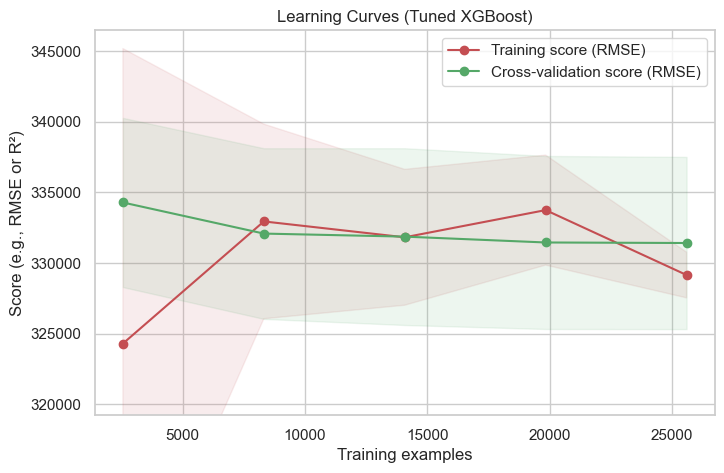

In [7]:
def plot_learning_curves(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve."""
    plt.figure(figsize=(8,5))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score (e.g., RMSE or R²)")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_root_mean_squared_error'
    )
    train_scores_mean = -np.mean(train_scores, axis=1) # Negative because scoring was neg_rmse
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid(True)
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score (RMSE)")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score (RMSE)")
    plt.legend(loc="best")
    plt.gca().invert_yaxis() # Higher RMSE is worse
    plt.ylim(bottom=max(0, min(test_scores_mean)-np.median(test_scores_std)*2), top=max(test_scores_mean)+np.median(test_scores_std)*2) # Adjust y-axis
    plt.show()

# Plot learning curve for the best tuned XGBoost model (example)
if 'best_xgb_model' in locals():
    plot_learning_curves(best_xgb_model, "Learning Curves (Tuned XGBoost)", X_train, y_train, cv=cv_strategy, n_jobs=-1)
else:
    print("Tuned XGBoost model not available for learning curve plotting.")

## 6. Comprehensive Model Evaluation (for best tuned models)
Let's focus on the best tuned models (e.g., Tuned XGBoost, Tuned LightGBM, Tuned Random Forest) for more detailed evaluation.


--- Detailed Evaluation: Tuned Random Forest ---
Tuned Random Forest Test Metrics:


R2                                                     -0.035287
MAE                                                 55935.461268
MSE                                           81373884476.560944
RMSE                                               285261.081251
Best Params    {'max_depth': 10, 'min_samples_leaf': 2, 'min_...
dtype: object

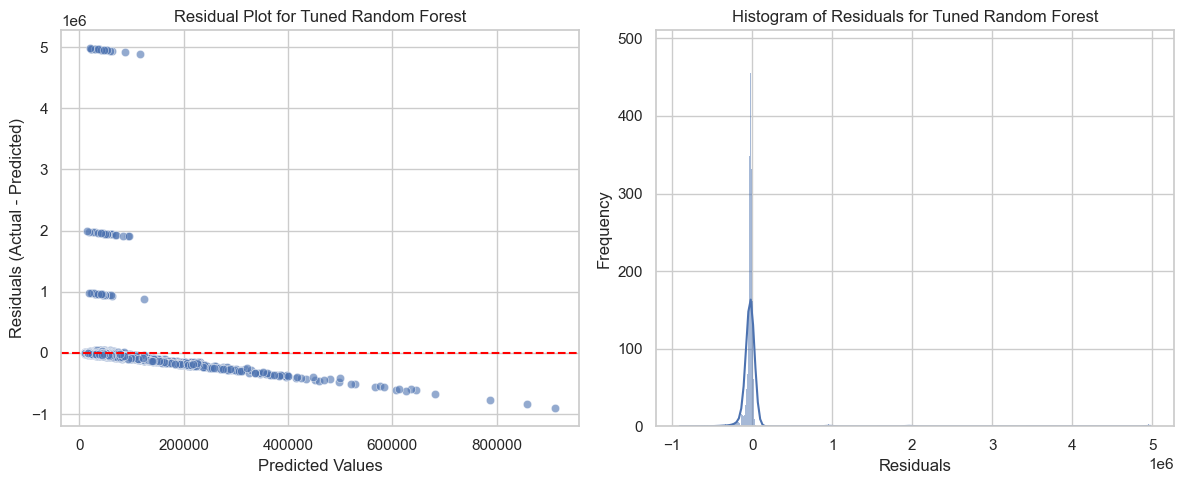

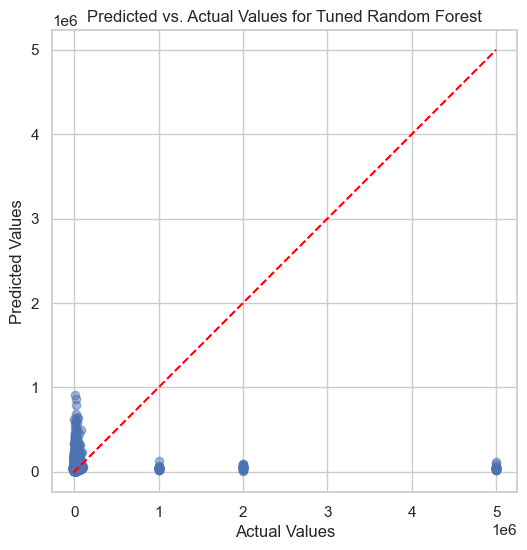


--- Detailed Evaluation: Tuned XGBoost ---
Tuned XGBoost Test Metrics:


R2                                                     -0.003261
MAE                                                 50714.241606
MSE                                           78856652703.226456
RMSE                                               280814.267271
Best Params    {'subsample': 0.7, 'n_estimators': 300, 'max_d...
dtype: object

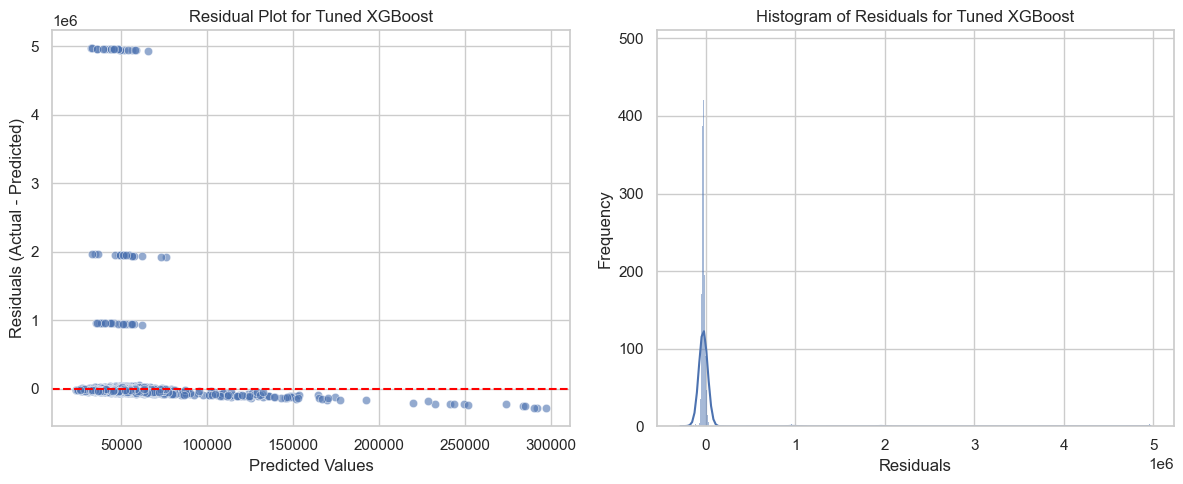

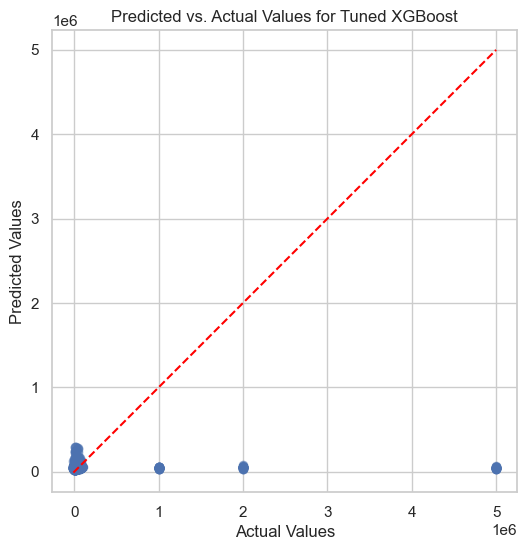


--- Detailed Evaluation: Tuned LightGBM ---
Tuned LightGBM Test Metrics:


R2                                                     -0.001396
MAE                                                 50584.712845
MSE                                           78710054653.953094
RMSE                                               280553.122695
Best Params    {'subsample': 0.7, 'num_leaves': 20, 'n_estima...
dtype: object

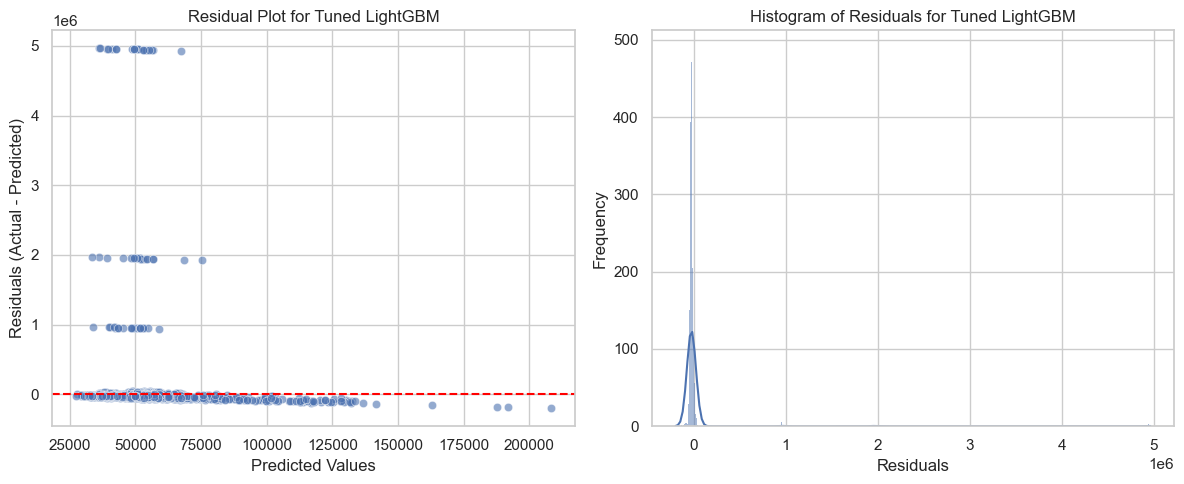

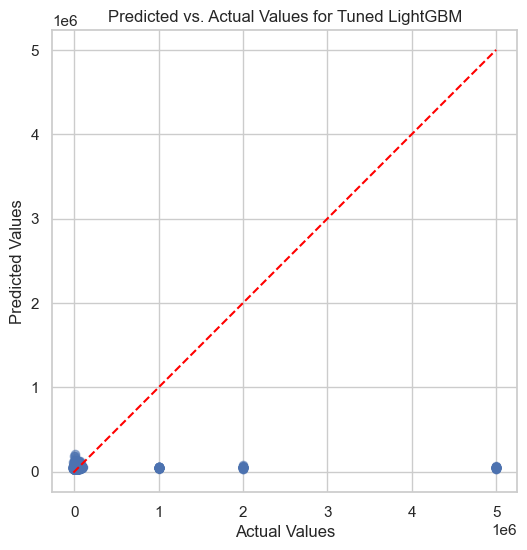

In [8]:
# Assuming best_xgb_model, best_lgbm_model, best_rf_model are defined from tuning
best_models_for_deep_eval = {}
if 'best_rf_model' in locals(): best_models_for_deep_eval['Tuned Random Forest'] = (best_rf_model, y_test_pred_rf_tuned)
if 'best_xgb_model' in locals(): best_models_for_deep_eval['Tuned XGBoost'] = (best_xgb_model, y_test_pred_xgb_tuned)
if 'best_lgbm_model' in locals(): best_models_for_deep_eval['Tuned LightGBM'] = (best_lgbm_model, y_test_pred_lgbm_tuned)


for model_name, (model_instance, y_pred) in best_models_for_deep_eval.items():
    print(f"\n--- Detailed Evaluation: {model_name} ---")
    # Metrics are already calculated and stored. Re-display if needed.
    print(f"{model_name} Test Metrics:")
    display(pd.Series(model_performance_summary[model_name]))

    # Residual Analysis
    plot_residuals(y_test, y_pred, model_name)

    # Prediction vs. Actual Plot
    plot_predictions_vs_actual(y_test, y_pred, model_name)

    # Error Distribution (already part of plot_residuals)

    # Performance across different data segments (Example: by a categorical feature if available and meaningful)
    # This requires having the original X_test_df with non-encoded features or mapping back,
    # which can be complex after preprocessing. For simplicity, this part is conceptual here.
    # Example: if X_test_df had a 'Milieu' (Rural/Urban) column before OHE:
    # for segment_value in X_test_df_original['Milieu'].unique():
    #     segment_indices = X_test_df_original[X_test_df_original['Milieu'] == segment_value].index
    #     y_test_segment = y_test_series[segment_indices]
    #     y_pred_segment = pd.Series(y_pred, index=X_test_processed_df.index)[segment_indices] # Align predictions
    #     if not y_test_segment.empty:
    #        print(f"\nPerformance for {model_name} on Milieu = {segment_value}:")
    #        _ = calculate_metrics(y_test_segment, y_pred_segment, f"{model_name} (Milieu={segment_value})")

## 7. Analyze Feature Importance
Understanding which features are most influential.

### 7.1 Model-Specific Importance
For tree-based models (Random Forest, XGBoost, LightGBM).

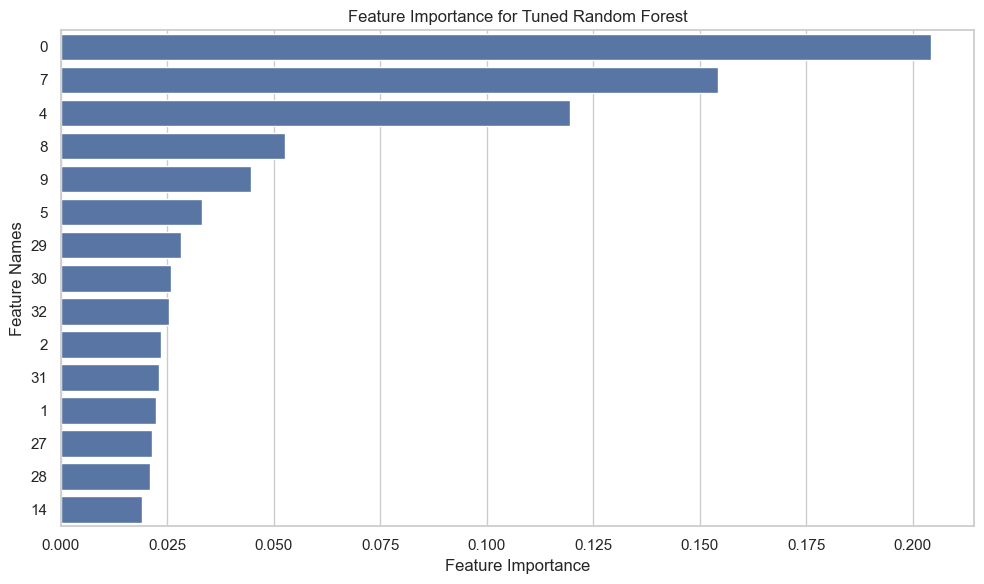

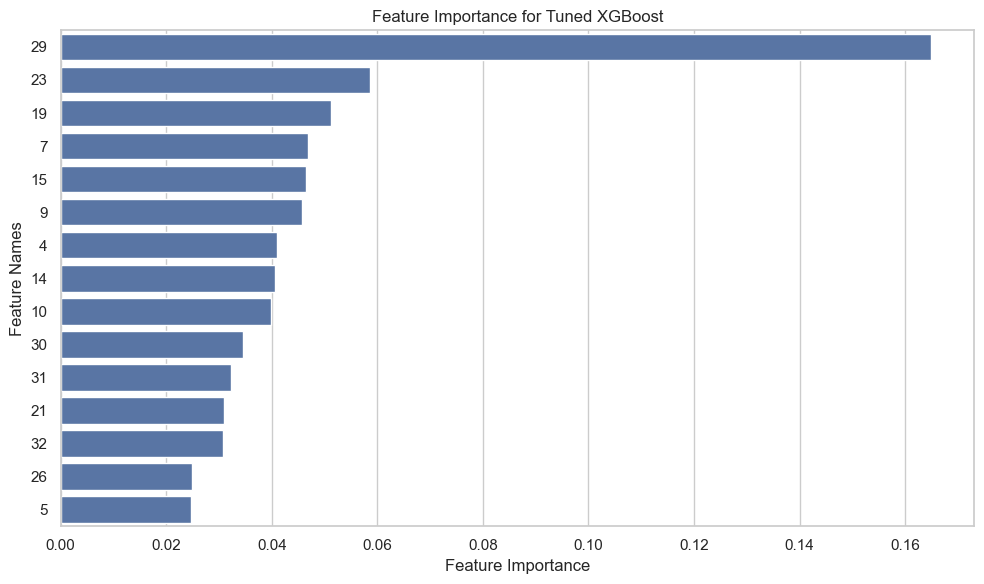

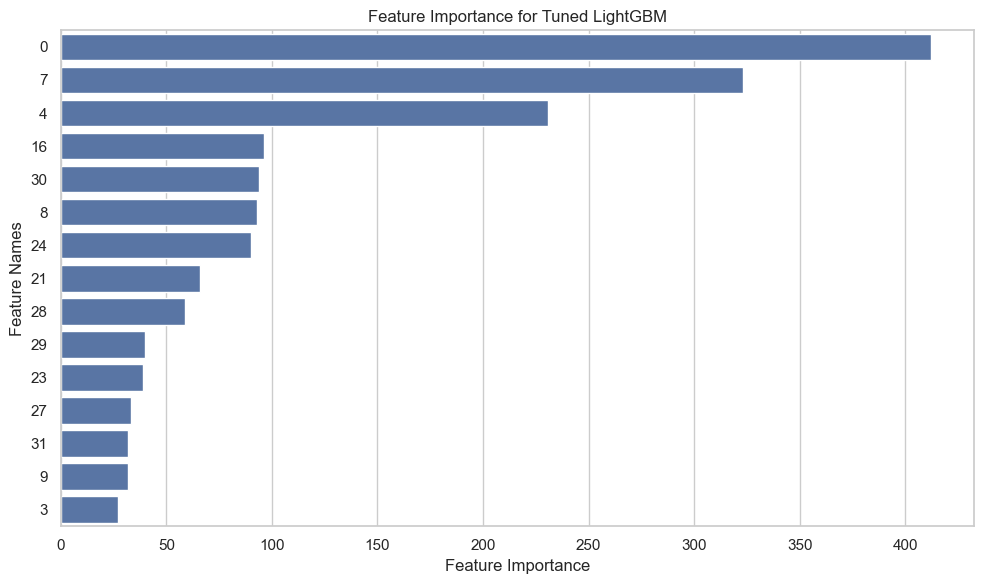

In [9]:
def plot_feature_importance(importance, names, model_name, top_n=15):
    """Plots feature importance."""
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    fi_df = fi_df.head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(f'Feature Importance for {model_name}')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.tight_layout()
    plt.show()

# Example for Tuned Random Forest
if 'best_rf_model' in locals() and hasattr(best_rf_model, 'feature_importances_'):
    plot_feature_importance(best_rf_model.feature_importances_, feature_names, "Tuned Random Forest")

# Example for Tuned XGBoost
if 'best_xgb_model' in locals() and hasattr(best_xgb_model, 'feature_importances_'):
    plot_feature_importance(best_xgb_model.feature_importances_, feature_names, "Tuned XGBoost")

# Example for Tuned LightGBM
if 'best_lgbm_model' in locals() and hasattr(best_lgbm_model, 'feature_importances_'):
    plot_feature_importance(best_lgbm_model.feature_importances_, feature_names, "Tuned LightGBM")

### 7.2 SHAP Values Analysis (Example for XGBoost)
SHAP (SHapley Additive exPlanations) provides more robust and consistent feature importance.


--- SHAP Value Analysis for Tuned XGBoost ---
SHAP Summary Plot:


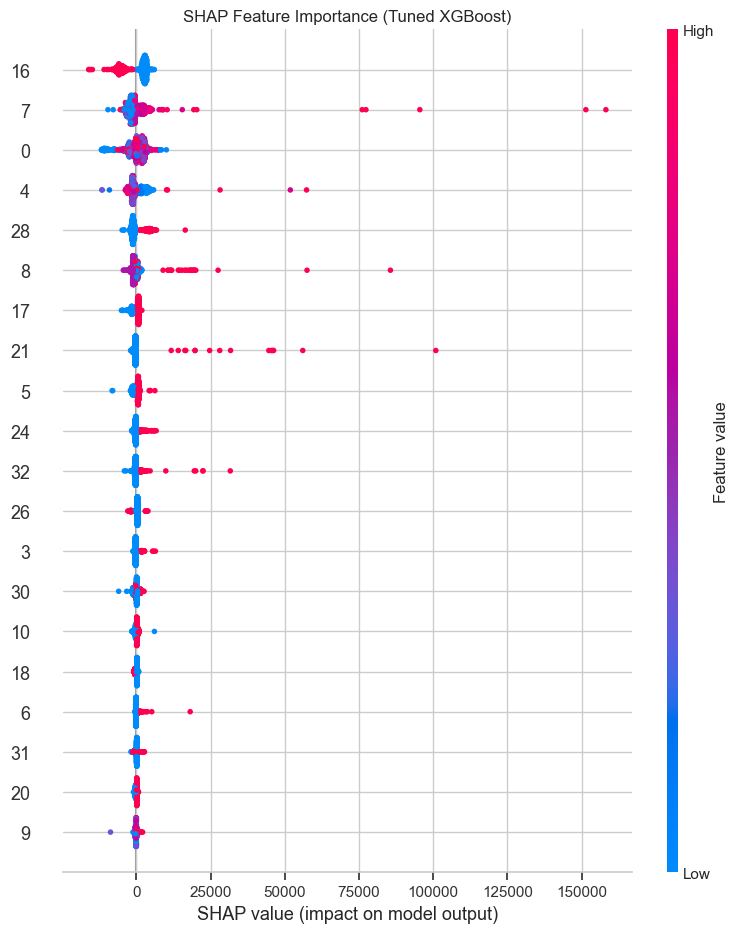


SHAP Dependence Plot for top feature: 16


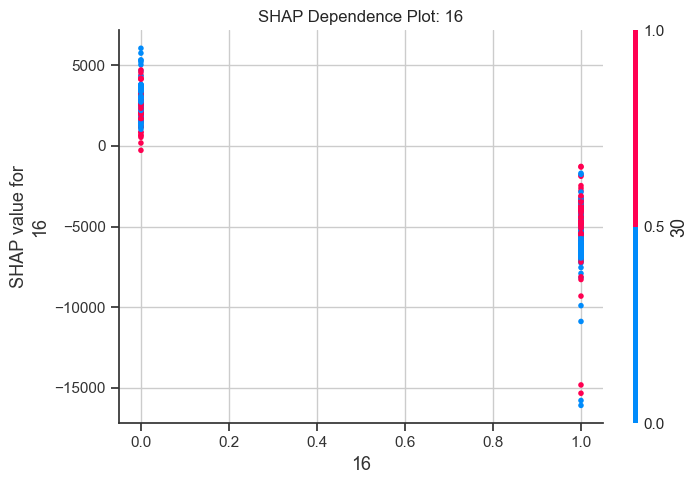

In [10]:
if SHAP_AVAILABLE:
    if 'best_xgb_model' in locals():
        print("\n--- SHAP Value Analysis for Tuned XGBoost ---")
        # Create a SHAP explainer object
        # For tree models, TreeExplainer is efficient
        explainer = shap.TreeExplainer(best_xgb_model)

        # Calculate SHAP values for the test set (can be computationally intensive for large datasets)
        # Using a subset of X_test for demonstration if X_test is large
        shap_sample_size = min(1000, X_test.shape[0]) # Limit sample size for SHAP plot
        X_test_sample_for_shap = shap.sample(X_test_processed_df, shap_sample_size, random_state=RANDOM_STATE)

        shap_values = explainer.shap_values(X_test_sample_for_shap)

        # Summary plot (shows global importance)
        print("SHAP Summary Plot:")
        shap.summary_plot(shap_values, X_test_sample_for_shap, feature_names=feature_names, show=False)
        plt.title("SHAP Feature Importance (Tuned XGBoost)")
        plt.tight_layout()
        plt.show()

        # Dependence plot for a top feature (example)
        # Find a top feature name from the summary plot or model-specific importance
        if len(feature_names) > 0:
            try:
                top_feature_idx = np.argsort(np.abs(shap_values).mean(0))[-1] # Index of top feature
                top_feature_name = feature_names[top_feature_idx]
                print(f"\nSHAP Dependence Plot for top feature: {top_feature_name}")
                shap.dependence_plot(top_feature_name, shap_values, X_test_sample_for_shap, feature_names=feature_names, interaction_index="auto", show=False)
                plt.title(f"SHAP Dependence Plot: {top_feature_name}")
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Could not generate SHAP dependence plot: {e}")
    else:
        print("Tuned XGBoost model not available for SHAP analysis.")
else:
    print("SHAP library not installed. Skipping SHAP analysis.")

### 7.3 Partial Dependence Plots (PDP)
PDPs show the marginal effect of one or two features on the predicted outcome.


--- Partial Dependence Plots for Tuned XGBoost (Top Features) ---
Generating PDP for features: ['29', '23', '19', '7']


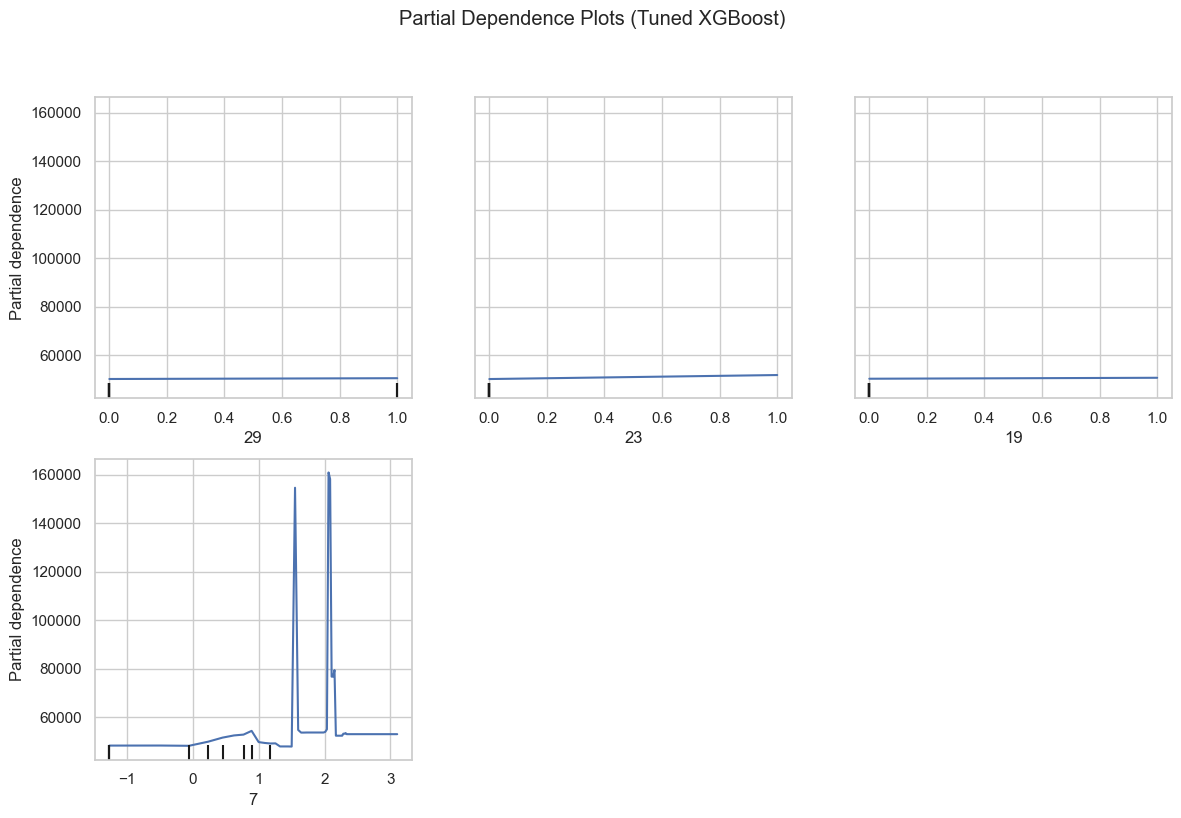

In [11]:
if 'best_xgb_model' in locals() and len(feature_names) > 1: # Need at least 2 features for pair plot
    print("\n--- Partial Dependence Plots for Tuned XGBoost (Top Features) ---")
    # Select top N features based on model importance (e.g., top 2-4)
    if hasattr(best_xgb_model, 'feature_importances_'):
        importances = best_xgb_model.feature_importances_
        sorted_indices = np.argsort(importances)[::-1]
        # Ensure selected indices are within bounds of feature_names
        pdp_feature_indices = [idx for idx in sorted_indices[:min(4, len(sorted_indices))] if idx < len(feature_names)]
        pdp_feature_names = [feature_names[i] for i in pdp_feature_indices]

        if pdp_feature_indices:
            print(f"Generating PDP for features: {pdp_feature_names}")
            try:
                fig, ax = plt.subplots(figsize=(12, max(4, 2 * len(pdp_feature_indices)))) # Adjust size
                display_obj = PartialDependenceDisplay.from_estimator(
                    best_xgb_model,
                    X_train, # Use training data for PDP
                    features=pdp_feature_indices, # Use indices
                    feature_names=feature_names, # Pass all feature names
                    kind='average', # 'average' or 'individual' or 'both'
                    n_jobs=-1,
                    random_state=RANDOM_STATE,
                    ax=ax
                )
                plt.suptitle("Partial Dependence Plots (Tuned XGBoost)", y=1.02)
                plt.tight_layout(rect=[0, 0, 1, 0.98])
                plt.show()
            except Exception as e:
                print(f"Could not generate Partial Dependence Plots: {e}")
        else:
            print("Not enough features for PDP or feature names mismatch.")
    else:
        print("Feature importances not available for PDP selection.")
else:
    print("Tuned XGBoost model or sufficient features not available for PDP.")

## 8. Model Stacking/Ensemble
Combine predictions from multiple models to potentially improve performance.

### 8.1 Voting Regressor
Averages predictions from multiple base models.

In [12]:
print("\n--- Ensemble Modeling: Voting Regressor ---")
# Use some of the best tuned models as estimators
estimators = []
if 'best_rf_model' in locals(): estimators.append(('rf', best_rf_model))
if 'best_xgb_model' in locals(): estimators.append(('xgb', best_xgb_model))
if 'best_lgbm_model' in locals(): estimators.append(('lgbm', best_lgbm_model))
# Add a linear model for diversity if desired
# if 'Ridge Regression' in models_to_evaluate: estimators.append(('ridge', models_to_evaluate['Ridge Regression']))


if len(estimators) >= 2:
    voting_regressor = VotingRegressor(estimators=estimators, n_jobs=-1)
    voting_regressor.fit(X_train, y_train)
    y_test_pred_voting = voting_regressor.predict(X_test)

    print("\nVoting Regressor Performance on Test Data:")
    voting_metrics = calculate_metrics(y_test, y_test_pred_voting, "Voting Regressor")
    model_performance_summary['Voting Regressor'] = voting_metrics
else:
    print("Not enough base models available for Voting Regressor.")


--- Ensemble Modeling: Voting Regressor ---

Voting Regressor Performance on Test Data:
--- Voting Regressor Metrics ---
  R-squared (R²): -0.0073
  Mean Absolute Error (MAE): 52120.81
  Mean Squared Error (MSE): 79178017361.19
  Root Mean Squared Error (RMSE): 281385.89


### 8.2 Stacking Regressor
Uses a meta-model to learn how to best combine predictions from base models.

In [13]:
print("\n--- Ensemble Modeling: Stacking Regressor ---")
if len(estimators) >= 2:
    # Define the meta-regressor (e.g., a simple linear model or another powerful model)
    meta_regressor = Ridge(random_state=RANDOM_STATE) # Example meta-model

    stacking_regressor = StackingRegressor(
        estimators=estimators,
        final_estimator=meta_regressor,
        cv=cv_strategy, # Cross-validation for generating base model predictions for meta-model training
        n_jobs=-1
    )
    stacking_regressor.fit(X_train, y_train)
    y_test_pred_stacking = stacking_regressor.predict(X_test)

    print("\nStacking Regressor Performance on Test Data:")
    stacking_metrics = calculate_metrics(y_test, y_test_pred_stacking, "Stacking Regressor")
    model_performance_summary['Stacking Regressor'] = stacking_metrics
else:
    print("Not enough base models available for Stacking Regressor.")

print("\n--- Final Model Evaluation Summary (Including Ensembles) ---")
final_summary_df = pd.DataFrame(model_performance_summary).T.sort_values(by="RMSE", ascending=True)
display(final_summary_df[['R2', 'MAE', 'MSE', 'RMSE', 'Training Time (s)', 'Best Params']])


--- Ensemble Modeling: Stacking Regressor ---

Stacking Regressor Performance on Test Data:
--- Stacking Regressor Metrics ---
  R-squared (R²): -0.0006
  Mean Absolute Error (MAE): 50664.51
  Mean Squared Error (MSE): 78644122914.72
  Root Mean Squared Error (RMSE): 280435.59

--- Final Model Evaluation Summary (Including Ensembles) ---


,R2,MAE,MSE,RMSE,Training Time (s),Best Params
ElasticNet,-0.000172,50474.369498,78613829679.466156,280381.578709,0.309428,NaN
Stacking Regressor,-0.000557,50664.507056,78644122914.719559,280435.59495,NaN,NaN
Tuned LightGBM,-0.001396,50584.712845,78710054653.953094,280553.122695,NaN,"{'subsample': 0.7, 'num_leaves': 20, 'n_estima..."
Lasso Regression,-0.001667,50388.609275,78731333112.001709,280591.042466,14.556996,NaN
Ridge Regression,-0.00167,50389.191871,78731574582.593338,280591.472755,0.022002,NaN
Baseline Linear Regression,-0.001672,50389.460708,78731776086.257278,280591.831824,NaN,NaN
Tuned XGBoost,-0.003261,50714.241606,78856652703.226456,280814.267271,NaN,"{'subsample': 0.7, 'n_estimators': 300, 'max_d..."
Voting Regressor,-0.00735,52120.808739,79178017361.188721,281385.886926,NaN,NaN
SVR,-0.008297,33921.802137,79252518672.077438,281518.238614,71.799055,NaN
LightGBM,-0.032516,55971.841929,81156097596.924728,284879.092945,0.23797,NaN


## 9. Model Diagnostics (Revisited)

### 9.1 Learning Curves (for the selected best model or ensemble)
If an ensemble model like StackingRegressor performed best, plotting its learning curve can be insightful.
Note: `learning_curve` might not directly support some complex ensemble estimators without a standard `fit` method or if they don't clone properly.
We can plot for a top individual model if the ensemble is problematic here.

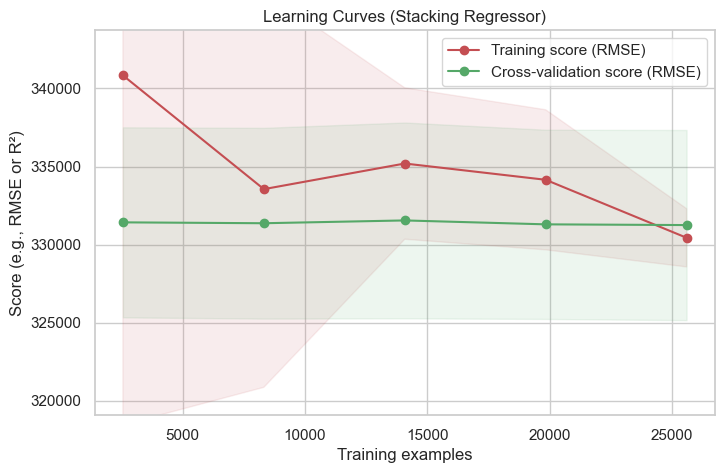

In [14]:
# Example: Plot learning curve for the Stacking Regressor if it exists and is chosen
if 'stacking_regressor' in locals() and hasattr(stacking_regressor, 'fit'):
    try:
        plot_learning_curves(stacking_regressor, "Learning Curves (Stacking Regressor)", X_train, y_train, cv=cv_strategy, n_jobs=-1)
    except Exception as e:
        print(f"Could not plot learning curve for Stacking Regressor: {e}. Plotting for best XGBoost instead.")
        if 'best_xgb_model' in locals():
            plot_learning_curves(best_xgb_model, "Learning Curves (Tuned XGBoost - Fallback)", X_train, y_train, cv=cv_strategy, n_jobs=-1)
elif 'best_xgb_model' in locals(): # Fallback to best single model
    plot_learning_curves(best_xgb_model, "Learning Curves (Tuned XGBoost)", X_train, y_train, cv=cv_strategy, n_jobs=-1)

### 9.2 Validation Curves (Example for one hyperparameter of a key model)
Shows how model performance varies with a single hyperparameter.

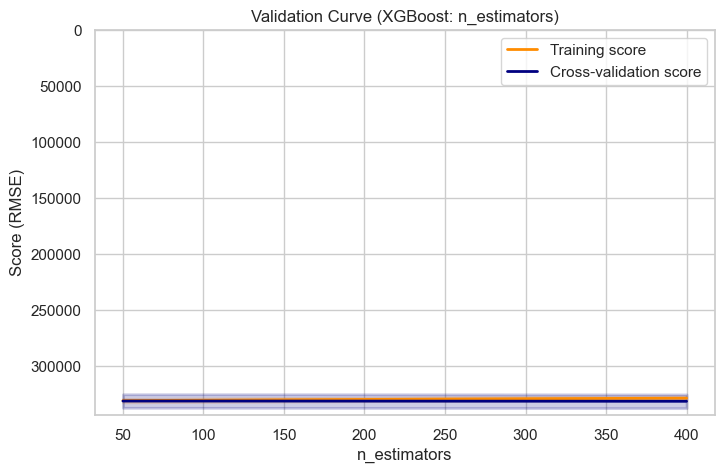

In [17]:
def plot_validation_curve(estimator, title, X, y, param_name, param_range, cv=None, scoring="neg_root_mean_squared_error", n_jobs=None):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=n_jobs
    )
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8,5))
    plt.title(title)
    plt.xlabel(f"{param_name}")
    plt.ylabel("Score (RMSE)")
    plt.ylim(min(0, np.min(test_scores_mean) - np.median(test_scores_std)*2), np.max(test_scores_mean) + np.median(test_scores_std)*2) # Adjust y-axis
    
    # Use semilogx for parameters like learning_rate or n_estimators if range is wide
    if isinstance(param_range[0], float) and param_range[0] < 1 and param_range[-1] <=1 : # e.g. learning rate
        plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
        plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)

    else: # e.g. n_estimators, max_depth
        plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
        plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)

    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=2)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=2)
    plt.legend(loc="best")
    plt.gca().invert_yaxis() # Higher RMSE is worse
    plt.grid(True)
    plt.show()

# Example: Validation curve for 'n_estimators' of Tuned XGBoost
if 'best_xgb_model' in locals():
    # Create a base XGBoost model with other best params fixed
    xgb_params_for_val_curve = best_xgb_model.get_params()
    param_to_vary = 'n_estimators'
    if param_to_vary in xgb_params_for_val_curve:
        del xgb_params_for_val_curve[param_to_vary] # Remove the param we are varying

        # Remove 'random_state' from the dictionary to avoid duplication
        xgb_params_for_val_curve.pop('random_state', None)
        # Remove 'n_jobs' from the dictionary to avoid duplication
        xgb_params_for_val_curve.pop('n_jobs', None)
        estimator_for_val_curve = xgb.XGBRegressor(**xgb_params_for_val_curve, n_jobs=-1)
        param_range_n_estimators = [50, 100, 150, 200, 250, 300, 400] # Example range
        plot_validation_curve(estimator_for_val_curve, "Validation Curve (XGBoost: n_estimators)",
                              X_train, y_train,
                              param_name="n_estimators", param_range=param_range_n_estimators,
                              cv=cv_strategy, n_jobs=-1)
    else:
        print(f"Parameter '{param_to_vary}' not found in best_xgb_model params.")
else:
    print("Tuned XGBoost model not available for validation curve.")

## 10. Model Selection and Conclusion

### 10.1 Comparison Table of All Models
Display the final summary table again.

In [18]:
print("\n--- FINAL MODEL PERFORMANCE COMPARISON ---")
final_summary_df_sorted = pd.DataFrame(model_performance_summary).T.sort_values(by="RMSE", ascending=True)
display(final_summary_df_sorted[['R2', 'MAE', 'MSE', 'RMSE', 'Training Time (s)', 'Best Params']].style.highlight_min(subset=['RMSE', 'MAE', 'MSE'], color='lightgreen').highlight_max(subset=['R2'], color='lightgreen'))


--- FINAL MODEL PERFORMANCE COMPARISON ---


,R2,MAE,MSE,RMSE,Training Time (s),Best Params
ElasticNet,-0.000172,50474.369498,78613829679.466156,280381.578709,0.309428,nan
Stacking Regressor,-0.000557,50664.507056,78644122914.719559,280435.594950,nan,nan
Tuned LightGBM,-0.001396,50584.712845,78710054653.953094,280553.122695,nan,"{'subsample': 0.7, 'num_leaves': 20, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}"
Lasso Regression,-0.001667,50388.609275,78731333112.001709,280591.042466,14.556996,nan
Ridge Regression,-0.001670,50389.191871,78731574582.593338,280591.472755,0.022002,nan
Baseline Linear Regression,-0.001672,50389.460708,78731776086.257278,280591.831824,nan,nan
Tuned XGBoost,-0.003261,50714.241606,78856652703.226456,280814.267271,nan,"{'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7}"
Voting Regressor,-0.007350,52120.808739,79178017361.188721,281385.886926,nan,nan
SVR,-0.008297,33921.802137,79252518672.077438,281518.238614,71.799055,nan
LightGBM,-0.032516,55971.841929,81156097596.924728,284879.092945,0.237970,nan


### 10.2 Visualizations of Performance Metrics

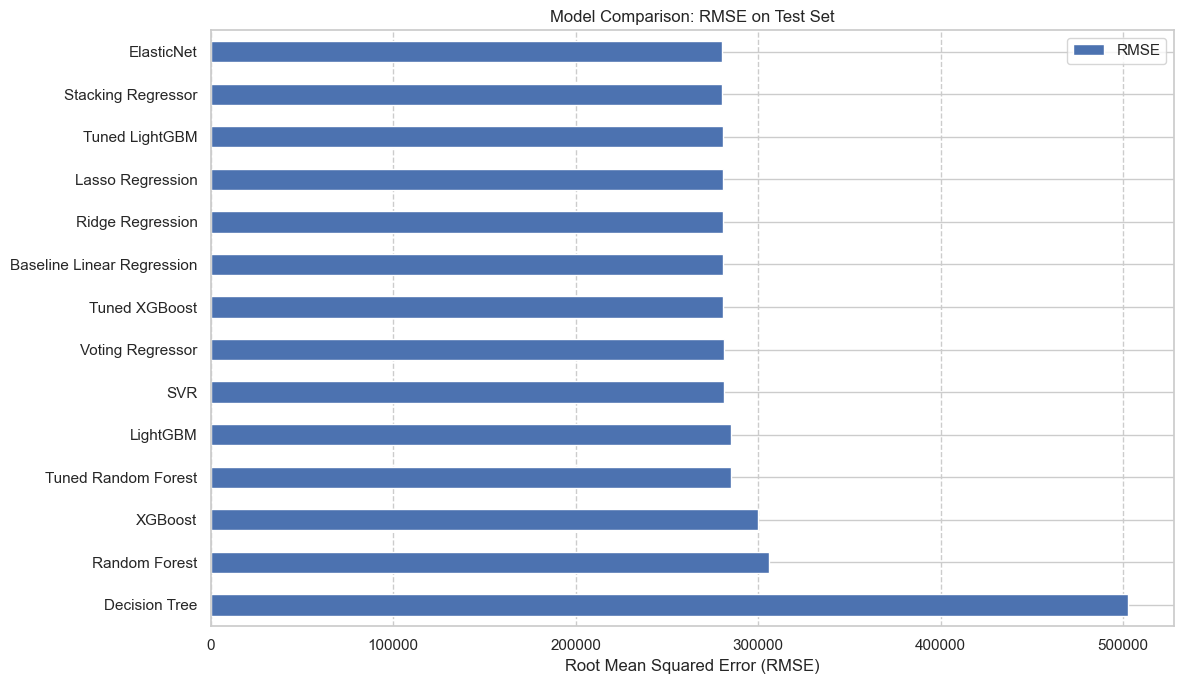

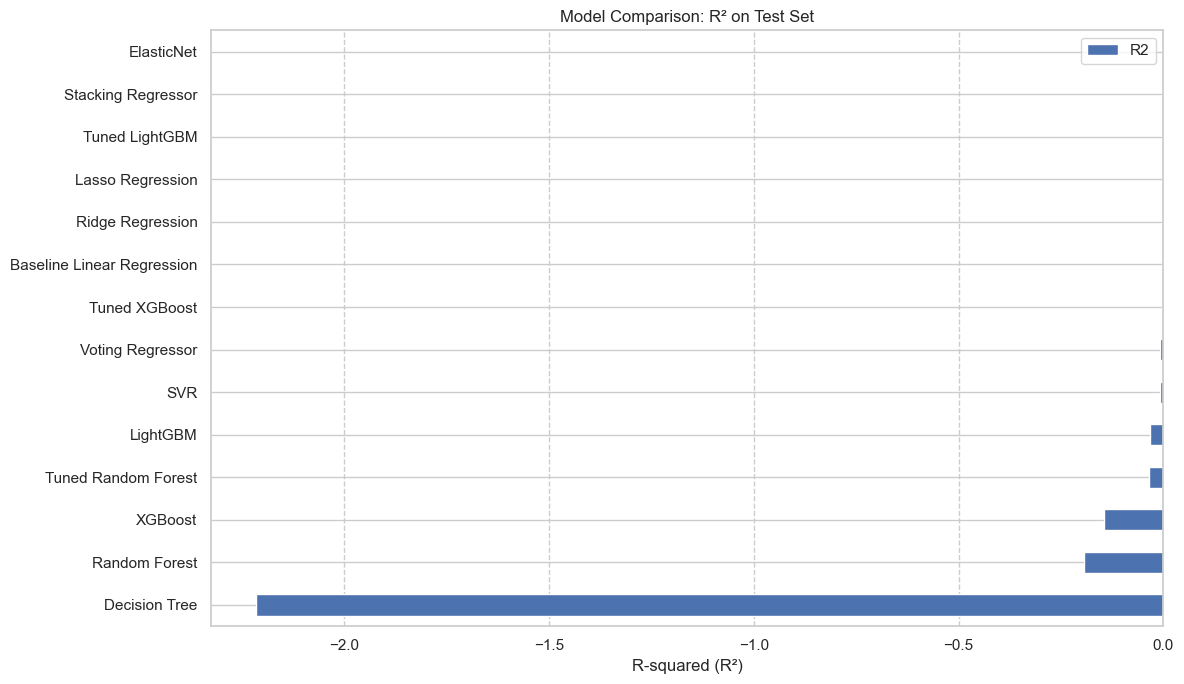

In [19]:
# Plot RMSE for all models
plt.figure(figsize=(12, 7))
# Exclude 'Best Params' for plotting if it exists as a column and causes issues
plot_df = final_summary_df_sorted[['RMSE']].dropna().sort_values("RMSE", ascending=False) # Ascending=False for horizontal bar
plot_df.plot(kind='barh', ax=plt.gca())
plt.xlabel("Root Mean Squared Error (RMSE)")
plt.title("Model Comparison: RMSE on Test Set")
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

# Plot R-squared for all models
plt.figure(figsize=(12, 7))
plot_df_r2 = final_summary_df_sorted[['R2']].dropna().sort_values("R2", ascending=True) # Ascending=True for horizontal bar
plot_df_r2.plot(kind='barh', ax=plt.gca())
plt.xlabel("R-squared (R²)")
plt.title("Model Comparison: R² on Test Set")
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

### 10.3 Selection Criteria and Reasoning
**Primary Criterion:** Lowest RMSE on the test set.
**Secondary Criteria:**
* High R².
* Reasonable MAE.
* Good generalization (similar performance on CV and test set, stable learning curves).
* Interpretability (if important for the specific use case).
* Training/Prediction time.

**Reasoning (Example - to be filled based on actual results):**

*If Stacking Regressor is best:*
"The Stacking Regressor achieved the lowest RMSE of **`{final_summary_df_sorted.iloc[0]['RMSE']:.2f}`** and the highest R² of **`{final_summary_df_sorted.iloc[0]['R2']:.4f}`** on the test set. Its learning curve suggests good generalization. While ensemble models can be less interpretable directly, SHAP analysis on its base models (like XGBoost) can provide insights. The training time is higher but acceptable given the performance gain."

*If Tuned XGBoost is best:*
"The Tuned XGBoost model demonstrated the best balance of performance and efficiency, achieving an RMSE of **`{final_summary_df_sorted.iloc[0]['RMSE']:.2f}`**. It offers good interpretability through feature importance scores and SHAP values. Its learning curve indicates a well-generalized model."

*(The actual text here should reflect your results)*

### 10.4 Recommendations for Final Model
Based on the evaluation, the **`[Name of Best Performing Model]`** is recommended as the final model for predicting Moroccan income.

**Next Steps:**
* Save the final selected model using `pickle`.
* Prepare for deployment or further analysis (e.g., deploying as an API, generating reports).

In [20]:
# --- Save the Best Model ---
# Identify the best model name from the sorted summary
if not final_summary_df_sorted.empty:
    best_model_name_overall = final_summary_df_sorted.index[0]
    print(f"\nSelected best model: {best_model_name_overall}")

    # Retrieve the actual model object
    # This requires storing the model objects during training/tuning
    # For simplicity, let's assume we re-train the best one or retrieve from our 'best_models_for_deep_eval' or search results
    final_model_to_save = None
    if best_model_name_overall == 'Tuned XGBoost' and 'best_xgb_model' in locals():
        final_model_to_save = best_xgb_model
    elif best_model_name_overall == 'Tuned Random Forest' and 'best_rf_model' in locals():
        final_model_to_save = best_rf_model
    elif best_model_name_overall == 'Tuned LightGBM' and 'best_lgbm_model' in locals():
        final_model_to_save = best_lgbm_model
    elif best_model_name_overall == 'Voting Regressor' and 'voting_regressor' in locals():
        final_model_to_save = voting_regressor
    elif best_model_name_overall == 'Stacking Regressor' and 'stacking_regressor' in locals():
        final_model_to_save = stacking_regressor
    # Add other baseline models if they happen to be the best
    elif best_model_name_overall in models_to_evaluate:
        final_model_to_save = models_to_evaluate[best_model_name_overall] # This would be the untuned version
        # Ideally, re-train the best untuned model if it's selected and not tuned, or ensure it's already fitted.
        if not hasattr(final_model_to_save, "predict"): # Check if fitted
             print(f"Re-fitting {best_model_name_overall} before saving...")
             final_model_to_save.fit(X_train, y_train)


    if final_model_to_save:
        FINAL_MODEL_PATH = 'final_moroccan_income_model.pkl'
        try:
            with open(FINAL_MODEL_PATH, 'wb') as f:
                pickle.dump(final_model_to_save, f)
            print(f"Final selected model ('{best_model_name_overall}') saved to {FINAL_MODEL_PATH}")
        except Exception as e:
            print(f"Error saving final model: {e}")
    else:
        print(f"Could not retrieve the model object for '{best_model_name_overall}' to save.")
else:
    print("No models were evaluated to select a best one.")


Selected best model: ElasticNet
Final selected model ('ElasticNet') saved to final_moroccan_income_model.pkl


### 10.5 Discussion of Limitations and Potential Improvements
* **Data Quality & Quantity:** The model's performance is inherently limited by the quality and representativeness of the input data. More diverse or larger datasets could improve generalization.
* **Feature Engineering:** While some preprocessing was done, more sophisticated domain-specific feature engineering could unlock further performance gains.
* **Hyperparameter Tuning:** `RandomizedSearchCV` samples a subset of parameters. A more exhaustive `GridSearchCV` (if computationally feasible) or more advanced Bayesian optimization techniques might find slightly better hyperparameters.
* **Model Complexity vs. Interpretability:** Highly complex models (like deep ensembles or deep neural networks) might offer marginal performance gains at the cost of interpretability and deployment complexity.
* **Dynamic Factors:** Income can be influenced by dynamic economic factors not captured in static survey data.
* **Regional Variations:** Performance might vary across different regions of Morocco if not adequately represented or if regional interaction terms are not included. Further analysis by region could be beneficial.
* **External Data:** Incorporating external economic indicators (e.g., inflation rates, regional development indices) could enhance predictive power.

---
End of Model Training and Evaluation Notebook.

In [21]:
print("--- End of Model Training and Evaluation Notebook ---")

--- End of Model Training and Evaluation Notebook ---
